In [63]:
import pandas as pd
import numpy as np

import glob
import os
import sys
import json

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F


In [60]:
from scr import utils, models_classes, preprocess
plt.rcParams.update({'font.size': 20})

# Performance metrics 

In [31]:
with open("output_kFold_together.json", "r") as f:
    scores_per_model = json.load(f)

In [32]:
print("Average scores over K-fold = 5 iterations for each model type:")
for model_name, scores in zip(scores_per_model["model_type"], scores_per_model["scores"]):
    print(f"Model: {model_name}")
    for metric, value in scores.items():
        print(f"  {metric}: {sum(value) / len(value):.4f} ± {np.std(value):.4f} ")

Average scores over K-fold = 5 iterations for each model type:
Model: SimpleLSTM
  accuracy_test: 0.7146 ± 0.0449 
  f1_test: 0.7213 ± 0.0337 
  recall_test: 0.7564 ± 0.0324 
  precision_test: 0.6906 ± 0.0446 
  accuracy_train: 0.7516 ± 0.0244 
  f1_train: 0.7568 ± 0.0289 
  recall_train: 0.7968 ± 0.0442 
  precision_train: 0.7210 ± 0.0182 
Model: StressClassifierWithFusion
  accuracy_test: 0.6943 ± 0.0543 
  f1_test: 0.7113 ± 0.0421 
  recall_test: 0.7713 ± 0.0413 
  precision_test: 0.6604 ± 0.0457 
  accuracy_train: 0.7375 ± 0.0492 
  f1_train: 0.7486 ± 0.0445 
  recall_train: 0.8014 ± 0.0412 
  precision_train: 0.7027 ± 0.0491 
Model: TCN_net
  accuracy_test: 0.6975 ± 0.0482 
  f1_test: 0.6988 ± 0.0420 
  recall_test: 0.7206 ± 0.0473 
  precision_test: 0.6788 ± 0.0421 
  accuracy_train: 0.7491 ± 0.0191 
  f1_train: 0.7524 ± 0.0162 
  recall_train: 0.7834 ± 0.0149 
  precision_train: 0.7241 ± 0.0226 


In [33]:
df_results_id05 = pd.DataFrame()
for model_name, scores in zip(scores_per_model["model_type"], scores_per_model["scores"]):
        df_results_id05 = pd.DataFrame(scores)
        display(df_results_id05)


,accuracy_test,f1_test,recall_test,precision_test,accuracy_train,f1_train,recall_train,precision_train
0,0.753404,0.756353,0.773700,0.739766,0.703787,0.700410,0.715750,0.685714
1,0.672761,0.691910,0.755639,0.638095,0.769726,0.779466,0.836861,0.729439
2,0.667864,0.678261,0.693950,0.663265,0.763135,0.762522,0.789097,0.737678
3,0.698413,0.717355,0.780576,0.663609,0.766003,0.775798,0.834225,0.725019
4,0.780622,0.762846,0.778226,0.748062,0.755575,0.765625,0.808160,0.727344


,accuracy_test,f1_test,recall_test,precision_test,accuracy_train,f1_train,recall_train,precision_train
0,0.751891,0.762319,0.804281,0.724518,0.701533,0.714901,0.773532,0.664532
1,0.687386,0.700525,0.751880,0.655738,0.710978,0.718698,0.759259,0.682250
2,0.619390,0.651316,0.704626,0.605505,0.833764,0.835605,0.876676,0.798210
3,0.654321,0.686901,0.773381,0.617816,0.731834,0.740369,0.787879,0.698262
4,0.758684,0.755556,0.822581,0.698630,0.709262,0.733491,0.809896,0.670259


,accuracy_test,f1_test,recall_test,precision_test,accuracy_train,f1_train,recall_train,precision_train
0,0.750378,0.757709,0.788991,0.728814,0.718215,0.725516,0.769804,0.686047
1,0.665448,0.659218,0.665414,0.653137,0.766295,0.763557,0.776014,0.751494
2,0.642729,0.653913,0.669039,0.639456,0.771318,0.772591,0.806077,0.741776
3,0.668430,0.684564,0.733813,0.641509,0.749135,0.754861,0.795900,0.717846
4,0.760512,0.738523,0.745968,0.731225,0.740566,0.745477,0.769097,0.723265


# Attention

In [47]:
model_class = models_classes.StressClassifierWithFusion

In [ ]:
#load data
X_test = torch.load("X_test.pt")
y_test = torch.load("y_test.pt")
BATCH_SIZE = 32
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
#load model
save_path = f'Cumulating_model.pth'
model_best = model_class()
model_best.load_state_dict(torch.load(save_path))
model_best.eval()

all_attn_weights = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_best(inputs) 
        attn_weights = model_best.get_attention_weights()  
        
        all_attn_weights.append(attn_weights)
        all_labels.append(labels)

# Concatenate all batches
all_attn_weights = torch.cat(all_attn_weights, dim=0)  
all_labels = torch.cat(all_labels, dim=0)

stress_attn = all_attn_weights[all_labels == 1]  # Load 
no_stress_attn = all_attn_weights[all_labels == 0]  # Rest

#  mean and std per time step
stress_mean = stress_attn.mean(dim=0).mean(dim=0).cpu() 
stress_std = stress_attn.mean(dim=0).std(dim=0).cpu()
no_stress_mean = no_stress_attn.mean(dim=0).mean(dim=0).cpu()
no_stress_std = no_stress_attn.mean(dim=0).std(dim=0).cpu()

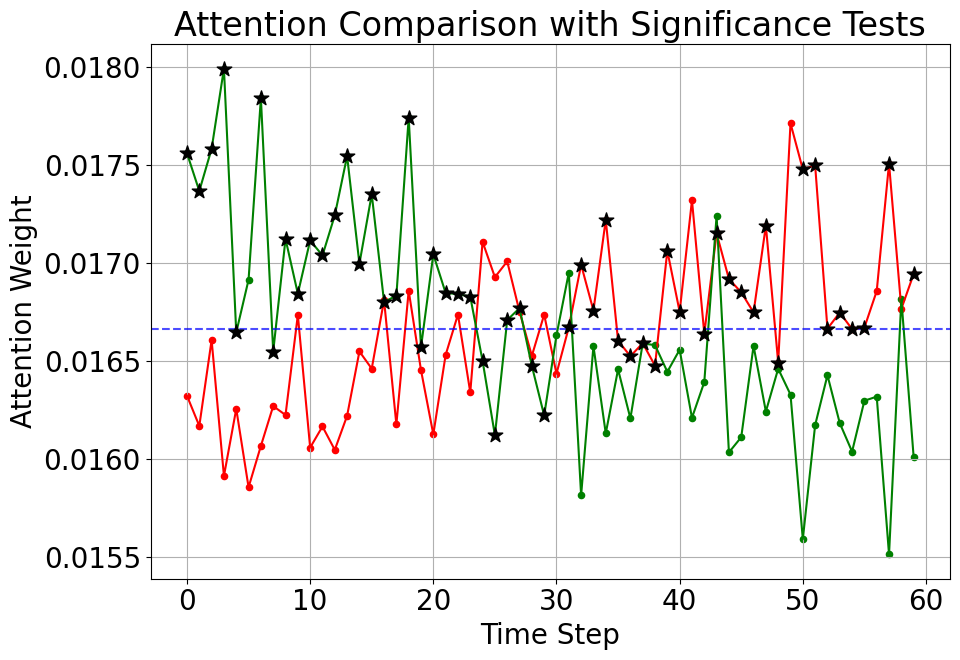

In [ ]:
from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu
from statsmodels.stats.multitest import multipletests

n_stress = stress_attn.shape[0]
n_no_stress = no_stress_attn.shape[0]
uniform_baseline_stress = np.full((n_stress, stress_attn.shape[1]), 1.0 / stress_attn.shape[1])
uniform_baseline_nostress = np.full((n_no_stress, no_stress_attn.shape[1]), 1.0 / no_stress_attn.shape[1])

def compute_p_values_fdr(data1, data2, alpha=0.05):
    raw_p_values = []

    data1 = np.array(data1)
    data2 = np.array(data2)

    for t in range(data1.shape[1]):
        x1 = data1[:, t].ravel() 
        x2 = data2[:, t].ravel()

        # Mann-Whitney U test
        _, p_val = mannwhitneyu(x1, x2, alternative='two-sided')
        raw_p_values.append(p_val)

    raw_p_values = np.array(raw_p_values)
    rejected, p_corrected, _, _ = multipletests(raw_p_values, alpha=alpha, method='fdr_bh')

    return p_corrected, rejected


# Compute FDR-corrected p-values
p_values_stress_vs_nostress, sig_stress_vs_nostress = compute_p_values_fdr(stress_attn, no_stress_attn)
p_values_stress_vs_uniform, sig_stress_vs_uniform = compute_p_values_fdr(stress_attn, uniform_baseline_stress)
p_values_nostress_vs_uniform, sig_nostress_vs_uniform = compute_p_values_fdr(no_stress_attn, uniform_baseline_nostress)

p_values_stress_vs_nostress = np.array(p_values_stress_vs_nostress)
p_values_stress_vs_uniform = np.array(p_values_stress_vs_uniform)
p_values_nostress_vs_uniform = np.array(p_values_nostress_vs_uniform)

plt.figure(figsize=(10, 7))
time_steps = range(stress_mean.shape[0])

# Plot
plt.plot(time_steps, stress_mean, label='attention curve for stress samples', color='red')
plt.plot(time_steps, no_stress_mean, label='attention curve for non-stress samples', color='green')

plt.axhline(y=1/60, color='b', linestyle='--', label='Uniform Importance', alpha=0.7)


# Mark significant differences
sig_stress_vs_uniform = np.where(p_values_stress_vs_uniform < 0.05)[0]
sig_nostress_vs_uniform = np.where(p_values_nostress_vs_uniform < 0.05)[0]
sig_stress_vs_nostress = np.where(p_values_stress_vs_nostress < 0.05)[0]

plt.scatter(sig_nostress_vs_uniform, stress_mean[sig_nostress_vs_uniform],
            color='red', marker='o', s=20, label='Stress vs Uniform (p<0.05)')
plt.scatter(sig_stress_vs_uniform, no_stress_mean[sig_stress_vs_uniform],
            color='green', marker='o', s=20, label='No-Stress vs Uniform (p<0.05)')

sig_stress_vs_nostress_green = sig_stress_vs_nostress[sig_stress_vs_nostress < 30]
sig_stress_vs_nostress_red = sig_stress_vs_nostress[sig_stress_vs_nostress >= 30]

# plt.scatter(sig_stress_vs_nostress, np.array([1/60]*len(sig_stress_vs_nostress)),
#             color='black', marker='*', s=100, label='Stress vs No-Stress (p<0.05)', zorder=5)

plt.scatter(sig_stress_vs_nostress_green, no_stress_mean[sig_stress_vs_nostress_green],
            color='black', marker='*', s=120, label='Stress vs No-Stress (p<0.05)', zorder=5)
plt.scatter(sig_stress_vs_nostress_red, stress_mean[sig_stress_vs_nostress_red],
            color='black', marker='*', s=120,  zorder=5)


# Labels and formatting
plt.title("Attention Comparison with Significance Tests")
plt.xlabel("Time Step")
plt.ylabel("Attention Weight")
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

